In [2]:
import csv
import unicodecsv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional

In [3]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/pranav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
vocab_size = 5000 # make the top list of words (common words)
embedding_dim = 50
max_length = 20
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # OOV = Out of Vocabulary

In [5]:
articles = []
val_articles = []
labels = []
val_labels = []

with open("train.tsv", 'r', encoding = 'utf-8') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    next(reader)
    for row in reader:
        labels.append(row[1])
        
        if(len(row)>13):
            article = row[2]+row[7]+row[13]
        else:
            article = row[2]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append(article)
        
train_articles = articles[0: 10239]
train_labels = labels[0: 10239]
        
with open("valid.tsv", 'r', encoding = 'utf-8') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    next(reader)
    for row in reader:
        val_labels.append(row[1])
        labels.append(row[1])
        if(len(row)>3):
            val_article = row[2]+row[3]
        else:
            val_article = row[2]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            val_article = val_article.replace(token, ' ')
            val_article = val_article.replace(' ', ' ')
        val_articles.append(val_article)
        
validation_articles = val_articles[0: 1283]
validation_labels = val_labels[0: 1283]

In [6]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index

In [7]:
train_sequences = tokenizer.texts_to_sequences(train_articles)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [8]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [23]:
print(set(labels))


{'true', 'barelyTrue', 'pantsFire', 'false', 'halfTrue', 'mostlyTrue'}


In [10]:
label_tokenizer.word_index

{'halftrue': 1,
 'false': 2,
 'mostlytrue': 3,
 'barelytrue': 4,
 'true': 5,
 'pantsfire': 6}

In [11]:
print(training_label_seq.shape)
print('-------------')
print(validation_label_seq.shape)

(10239, 1)
-------------
(1283, 1)


In [12]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
#model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(embedding_dim)))
model.add(Dense(7, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          250000    
_________________________________________________________________
bidirectional (Bidirectional (None, 100)               40400     
_________________________________________________________________
dense (Dense)                (None, 7)                 707       
Total params: 291,107
Trainable params: 291,107
Non-trainable params: 0
_________________________________________________________________


In [13]:
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy'],
)

In [14]:
num_epochs = 50
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/50
320/320 - 7s - loss: 1.7589 - accuracy: 0.2218 - val_loss: 1.7200 - val_accuracy: 0.2564
Epoch 2/50
320/320 - 3s - loss: 1.6090 - accuracy: 0.3196 - val_loss: 1.7352 - val_accuracy: 0.2440
Epoch 3/50
320/320 - 3s - loss: 1.3811 - accuracy: 0.4574 - val_loss: 1.8685 - val_accuracy: 0.2299
Epoch 4/50
320/320 - 3s - loss: 1.1392 - accuracy: 0.5692 - val_loss: 2.1132 - val_accuracy: 0.2354
Epoch 5/50
320/320 - 3s - loss: 0.9251 - accuracy: 0.6605 - val_loss: 2.4166 - val_accuracy: 0.2377
Epoch 6/50
320/320 - 3s - loss: 0.7266 - accuracy: 0.7420 - val_loss: 2.8251 - val_accuracy: 0.2416
Epoch 7/50
320/320 - 3s - loss: 0.5675 - accuracy: 0.8034 - val_loss: 3.3377 - val_accuracy: 0.2323
Epoch 8/50
320/320 - 4s - loss: 0.4452 - accuracy: 0.8467 - val_loss: 3.6394 - val_accuracy: 0.2323
Epoch 9/50
320/320 - 4s - loss: 0.3496 - accuracy: 0.8825 - val_loss: 4.1485 - val_accuracy: 0.2447
Epoch 10/50
320/320 - 4s - loss: 0.2901 - accuracy: 0.9032 - val_loss: 4.3181 - val_accuracy: 0.2268

In [15]:
test_labels = []
test_articles = []

with open("test.tsv", 'r', encoding = 'utf-8') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    next(reader)
    for row in reader:
        test_labels.append(row[1])
        if(len(row)>3):
            test_article = row[2]+row[3]
        else:
            test_article = row[2]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            test_article = test_article.replace(token, ' ')
            test_article = test_article.replace(' ', ' ')
        test_articles.append(test_article)

In [26]:
print((test_labels[0]))
print((test_articles[0]))

false
Wisconsin pace double number layoffs year.jobs


In [17]:
print(test_articles[0])

Wisconsin pace double number layoffs year.jobs


In [18]:
tokenizer.fit_on_texts(test_articles)
test_sequences = tokenizer.texts_to_sequences(test_articles)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [20]:
#svm = svm_wrapper(train_padded, test_padded)
test

NameError: name 'svm_wrapper' is not defined

In [19]:
i = 0
correct = 0.0;
total = 0.0;
ans = []
prediction = []
for i in range(len(test_articles)):
    txt = [];
    txt.append(test_articles[i])
    print(txt)
    seq = tokenizer.texts_to_sequences(txt)
    padded = pad_sequences(seq, maxlen=30)
    pred = model.predict(padded)
    labels = ['halfTrue', 'false', 'mostlyTrue', 'barelyTrue', 'true', 'pantsFire']
    prediction.append(labels[np.argmax(pred)-1])
    ans.append(test_labels[i])
    if(labels[np.argmax(pred)-1] == test_labels[i]):
        print("true" + "   || Truth:  " + test_labels[i] + " predicted: " + labels[np.argmax(pred)-1])
        correct += 1;
    else:
        print("false")
    total += 1;

['Wisconsin pace double number layoffs year.jobs']
false
['Says John McCain done nothing help vets.military,veterans,voting-record']
false
['Suzanne Bonamici supports plan cut choice Medicare Advantage seniors.medicare,message-machine-2012,campaign-advertising']
false
['When asked reporter whether hes center criminal scheme violate campaign laws, Gov. Scott Walker nodded yes.campaign-finance,legal-issues,campaign-advertising']
false
['Over past five years federal government paid $601 million retirement disability benefits deceased former federal employees.federal-budget,pensions,retirement']
false
['Says Tennessee law requires schools receive half proceeds -- $31 million per year -- half-cent increase Shelby County sales tax.county-budget,county-government,education,taxes']
false
['Says Vice President Joe Biden "admits American people scammed" economic stimulus package.economy,stimulus']
false
['Donald Trump marriage equality. He wants go back.gays-and-lesbians,marriage']
false
['We kn

true   || Truth:  halfTrue predicted: halfTrue
['Any state tax law start House renewal state hospital bed tax year started Senate, unconstitutional.state-finances,taxes']
false
['Every child born today inherits $30,000 share national debt stands $13 trillion.deficit']
false
['A strong bipartisan majority House Representatives voted defund Obamacare.congressional-rules,federal-budget,health-care']
false
['Proximity high-voltage power lines lowers property values much 30 percent.energy,environment,housing,recreation']
false
['What facts say ...the best scenario kids loving mom dad.children,diversity']
false
['Says Mark Neumann = Nancy Pelosifederal-budget,infrastructure,message-machine,transportation,voting-record']
false
['To hear Gov. Christie tell it, everything New Jersey going fine. Well I see another New Jersey 400,000 unemployed. One worst jobless rates country. Working middle class families seen costs soar, property taxes college tuition.education,jobs,taxes']
false
['Says delega

false
['The Iraq Study Group reported (Saddam Hussein) designs reviving nuclear program.iraq']
false
['The sex-offender registry around long time, research thats says positive impact public safety.crime']
true   || Truth:  mostlyTrue predicted: mostlyTrue
['Ronald Reagan raised national debt 18 times.deficit']
false
['On whether global warming man-made.climate-change,environment']
false
['The number inmates since 2000 death row dying natural causes surpassed number inmates executed.crime,legal-issues']
false
['Quite frankly, Bush years spending, multiplied Obama years mess.bipartisanship,debt,deficit,federal-budget']
true   || Truth:  mostlyTrue predicted: mostlyTrue
['Republicans proposed dozens (health care) solutions designed help control costs improve quality.health-care']
true   || Truth:  halfTrue predicted: halfTrue
['When union says I want eliminate tenure, thats true.education,state-budget,unions']
false
['Says Hillary Clinton donated every cent shes ever earned speaking fees 

true   || Truth:  barelyTrue predicted: barelyTrue
['If look results Obamacare, see emergency room visits 50 percent.polls']
false
['Loranne Ausley voted six times tax savings.taxes']
false
['Four state Assembly Democrats scored death blow northeast Wisconsins economy killing hundreds jobs potential Bass Pro Shops near Green Bay.environment,jobs']
false
['The president campaigned type legislation.federal-budget']
false
['One every three women abortion lifetime.abortion']
true   || Truth:  halfTrue predicted: halfTrue
['Barack Obama "is left announced Socialist United States Senate."candidates-biography']
false
['What president worst record female labor force participation? Barack Obama.history,labor,women,workers']
false
['Two million Latinos poverty today President Obamatook oath office less eight years ago.economy,immigration,poverty,welfare']
false
['The Social Security trust fund already facing imminent bankruptcy.social-security,taxes']
false
['Seven hundred thousand. Thats many C

false
['Barack Obama Hillary Clinton changed positions (on Iraq war withdrawal) follow Chris Dodd.iraq']
false
['Saturday Night Live executive producer Lorne Michaels could put jail amendment making fun politician.campaign-finance,legal-issues']
true   || Truth:  halfTrue predicted: halfTrue
['When worked ATT, "was responsible large parts $5 billion organization."job-accomplishments']
false
['6,400 Ohioans ... lost manufacturing jobs month September.economy,jobs']
false
['Mitch McConnell voted Harry Reid infringe gun rights.congress,guns']
false
['Says Ron Johnson gave $10 million sweetheart corporate payoutsmall-business']
true   || Truth:  halfTrue predicted: halfTrue
['Of roughly 15 percent Americans dont health insurance, half made $50,000 year.health-care,income']
false
['The United States immediately tap domestic energy resource 1.5 trillion barrels oil, six times Saudi Arabia.climate-change,energy,environment,foreign-policy,gas-prices']
false
['Says House Democrats voted use tax

false
['Says Tom Ganley sued 400 times, fraud, discrimination more, judge called Tom Ganleys business practices deceptive unconscionable.job-accomplishments,message-machine']
true   || Truth:  mostlyTrue predicted: mostlyTrue
['A recall election Wisconsin governor would cost $7.7 million -- $7.7 million may already allocated merit raises teachers health care poor school books kids.education,elections,health-care,state-budget']
false
['Says plan property tax cut.state-budget,taxes']
true   || Truth:  halfTrue predicted: halfTrue
['We giving almost $2 billion taxpayer money junk food fast food industries every year make (childhood obesity) epidemic worse.consumer-safety,food-safety,health-care,taxes']
true   || Truth:  false predicted: false
['Not one American flag massive stage Democratic National Convention people started complaining- small one. Pathetic.patriotism']
false
['A bill Earl Blumenauer would mandate GPS tracking devices vehicles.privacy,transportation']
false
['As prosecuto

false
['There nothing current state public records law prohibits sensitive confidential business information that, confidential.government-efficiency,jobs']
false
['We even federal income tax country 1913.history,taxes']
true   || Truth:  mostlyTrue predicted: mostlyTrue
['The White House swing states, I winning swing states.elections']
false
['Says opponent U.S. Rep. Gwen Moore Wisconsins absent member Congress, missing nearly 17 percent House votes second quarter 2012.voting-record']
false
['Says Gov. Scott Walker dropped kicked college short degree long kicked student elections Marquette University.candidates-biography,education']
false
['Eliminating affirmative action admissions Florida led African American Hispanic kids attending university system before.education']
false
['When comes transportation funds, Georgians spend taxes red tape get back federal government.taxes,transportation']
false
['Federal stimulus money went Georgia Tech project apparently involve professor jamming w

false
['The problem raising tax rates wealthiest Americans half small business owners.deficit,federal-budget,taxes']
false
['Franklin Roosevelt never allocated 12 percent GDP federal spending, percentage Barack Obama projected drop 22.8 percent.federal-budget,pundits']
false
['Fifty-seven Rubios 100 ideas ultimately became law.candidates-biography,florida']
true   || Truth:  halfTrue predicted: halfTrue
['Ninety-six percent failing schools spending $8,400, average annual per student expenditure, 26 percent spend considerably that.education']
false
['About 78 81 House Democrats members Communist Party. ... Its called Congressional Progressive Caucus.candidates-biography']
false
['Military spending cuts, known sequester, President Barack Obamas idea.federal-budget,military']
false
['George Bush, Republican Congress, presided 55 percent increase size domestic government spending last seven years.federal-budget']
true   || Truth:  mostlyTrue predicted: mostlyTrue
['Clinton aides admit (a g

true   || Truth:  halfTrue predicted: halfTrue
['Over half people disability either anxious back hurts.disability']
false
['The Democrats Senate members Congress defended Fannie Freddie doing. They resisted change.economy']
true   || Truth:  halfTrue predicted: halfTrue
['Today California kicking butt, creating jobs economic growth Texas.economy,jobs,states']
false
['Says Gov. Mike Pence Rep. Mike Coffman take positions number things... Coffman Pence oppose equal rights LGBT Americans.gays-and-lesbians']
false
['All Floridas four-year state colleges offer bachelors degrees $10,000.education']
false
['One every two Wisconsin residents kind government handout.federal-budget,medicare,social-security']
false
['A new ruling EPA would force dairy farmers comply Spill Prevention, Control Countermeasure Program dealing spilt milk -- regulations oil natural gas producers must follow.environment']
true   || Truth:  false predicted: false
['Last year, zero percent growth GDP Virginia ...The state

false
['The permission engage given word RPG ever used.ethics,human-rights,military']
false
['Senator Obama voted 94 times either increase taxes tax cuts.taxes']
false
['Lorain poorest urban school district state Ohio.education,poverty,state-budget']
false
['The Senate health care bill contain limits medical malpractice lawsuits.health-care']
false
['Narragansett Bay waters getting warmer -- 4 degrees Fahrenheit warmer winter since 1960s.climate-change,environment,history,science']
false
['Says Barack Obama legal authority let really however many refugees wants, whatever country.federal-budget,foreign-policy,immigration,terrorism']
false
['Of cities United States 100,000 people, Providence 183rd safest.crime']
false
["In Japan, executives failing companies say 'I'm sorry' either one two things: resign go commit suicide.ethics"]
false
['Says President Barack Obama said American exceptionalism exceptional exceptionalism country.foreign-policy,patriotism']
false
['Says Barack Obamas favor

false
['In Texas, created 1 million new jobs rest nation lost 2 million.job-accomplishments,jobs,message-machine-2012']
true   || Truth:  halfTrue predicted: halfTrue
['Women come recession worse men numbers bear out. We went 7 percent unemployment rate women (President Barack Obama) elected 8.1 percent now.economy,jobs']
false
["The fact matter colleague New York, Senator Clinton, 50 percent American public say they're going vote her.elections"]
true   || Truth:  mostlyTrue predicted: mostlyTrue
['A $250 fine youre caught plastic bag coming store. Plastic bag police anyone?environment']
false
['In countries higher, strict gun laws, gun violence.guns']
false
['Says never wanted raise debt ceiling.debt,federal-budget']
false
['Thanks (North Carolinas) governor legislature, average teachersalary barely support family.education,families,state-budget,workers']
false
['There never really Hastert Rule.congressional-rules']
true   || Truth:  halfTrue predicted: halfTrue
['Says Donald Trump wa

false
['Agriculture always required significant workforce abroad.agriculture,history,immigration,workers']
false
['Says Jon Huntsman supports changes Medicare would deny guaranteed benefits 980,000 New Hampshire residents.medicare,new-hampshire-2012']
false
['Across United States, 25 percent voting age African Americans photo ID bill would require.elections']
false
['Says Rick Scott stripped women access public health care.abortion']
false
['A majority Americans agree ban assault weapons. And way, Ronald Reagan.guns']
false
['Only 42 percent young Georgians college certificate degree, soon 60 percent jobs require college credential.education,jobs']
false
['Texas lowest crime rate state since 1968 changes law regarding nonviolent drug offenders.crime,criminal-justice,drugs']
false
['Says HJM 20 bill assigned House committee.government-efficiency']
false
['Says try hide marijuana hemp field, becomes worthless. The THC goes away.drugs,government-regulation,marijuana,market-regulation,scie

false
['170,000 jobs created Texas Gov. Rick Perry government jobs.economy,jobs,state-budget,state-finances,states,workers']
false
['Says 97 percent food stamp benefits paid proper amounts people really eligible.agriculture,poverty']
false
['To day, (the Cuban government) regime provides safe harbor terrorists fugitives.foreign-policy,terrorism']
false
['The Senate passed budget three years, good budget, bad budget, budget.federal-budget']
false
['Congress includes 36 people accused spousal abuse, 84 arrested drunk driving past year, 71 terrible creditand more.congress,crime,ethics']
false
['Says initial Portland plastic bag ban represented modest share total single-use checkout bag use.city-government']
false
['The Bundy Ranch deal Nevada Sen. Harry Reid using federal violence take peoples land state package re-sell Chinese.china,environment,government-regulation']
false
["There's evidence anywhere offshore drilling hurt tourism area allowed.energy,environment"]
false
['Says Wisconsin

false
['In 2009, FBI referred 71,000 cases people failing background checks trying buy gun another federal agency, U.S. attorneys ultimately prosecuted 77 them.crime,criminal-justice,government-regulation,guns']
false
['Says Barack Obama first president modern history single year 3 percent growth.economy']
true   || Truth:  mostlyTrue predicted: mostlyTrue
['Half hospitalized seniors suffering malnutrition severe either caused illness prevents getting better.health-care,hunger,poverty']
false
['Under conservative leadership, Congress reduced federal deficit 60 percent nearly $800 billion.congress,deficit,economy,federal-budget']
false
['Says Patrick Murphy never worked CPA never small business owner.candidates-biography']
false
['In 2012, Wall Street gave Scott Brown campaign contributions candidate -- $5.3 million.campaign-finance,financial-regulation,message-machine-2014']
false
['$65 billion would added deficit keep cuts people highest incomes.federal-budget,taxes']
true   || Truth:

true   || Truth:  halfTrue predicted: halfTrue
['Rick Scott says supported in-state tuition Dreamers Charlie Crist it.education,immigration']
true   || Truth:  halfTrue predicted: halfTrue
['Black children constitute 18 percent nations public school population 40 percent children suspended expelled.civil-rights,education']
false
['I opposed TPP (Trans-Pacific Partnership) always opposed TPP.trade']
false
['President Obama liberal former DNC Chairman Tim Kaines $787 billion stimulus failed create jobs.deficit,economy,stimulus']
false
['Says eight years Florida governor, created 1.3 million net new jobs -- jobs created Texas.economy,jobs']
true   || Truth:  mostlyTrue predicted: mostlyTrue
['Marco Rubio\'s "income skyrocketed power increased."candidates-biography']
false
['This ban apply Oregon commercial fishermen. Washington commercial fishermen would still allowed use gillnets Columbia River.elections,environment,government-regulation']
false
['Says Republican recall challenger Jonath

true   || Truth:  mostlyTrue predicted: mostlyTrue
['The Obama administrations green stimulus program funneled close $2 billion dollars overseas firms, creating thousands jobs China.china,jobs,message-machine-2012,stimulus']
false
['The worlds 62 richest people wealth 3.6 billion poorest.poverty']
false
['There approximately 18,000 (police) departments United States.crime,criminal-justice']
false
['The cost-of-living increase Social Security tied wage inflation.social-security']
false
['Nearly quarter adults state college credit without degree.economy,education,jobs']
false
['Of 1.3 million temporary mortgage modifications, half defaulted.housing']
true   || Truth:  halfTrue predicted: halfTrue
['Republicans tried block deficit commission.federal-budget']
true   || Truth:  halfTrue predicted: halfTrue
['The state able sharply curtail contract bargaining rights state employee unions.jobs,labor,state-budget']
true   || Truth:  mostlyTrue predicted: mostlyTrue
['On support sharply limitin

false
['Scientists tell us could cure 10 years Alzheimers overzealous regulators, excessive taxation greedy litigators.government-regulation,health-care,market-regulation,science']
false
['Mitt Romney made hundred million dollars shutting (a Marion, Ind. paper) plant.candidates-biography,corporations,message-machine-2012']
false
['More people struck lightning commit in-person voter fraud impersonation.civil-rights,crime,elections,government-regulation']
false
['Says Hillary Clinton Tim Kaine want expand (Obamacare) single-payer program.drugs,health-care,history']
false
['Says last non-partisan commission improve voting experience America concluded #VoterID necessary.elections']
false
['Oregon school districts directing 24 percent food budgets purchase local foods. Thats highest percentage country.agriculture']
false
['Germany crime-riddled right migration Europe.crime,criminal-justice,human-rights,immigration,public-safety']
false
['Says theCongressional Budget Officehas estimatedevery

false
['In Ohio, year estimated 1,000 children become victims human trafficking, 3,000 risk.children,trade']
false
['Claims Obama said, "For oppose policies, shut go away."elections,florida']
false
['Says, Yet Salem traditionally waited money almost gone pay important things states budget.education,state-budget']
false
['18 percent land state right either federally, state county owned conservation purposes.animals,environment,recreation,state-finances']
false
["The race tighten, that's happens end campaigns. They always have.elections"]
true   || Truth:  mostlyTrue predicted: mostlyTrue
['Even Obamacare fully implemented, still tens millions people covered.health-care']
false
['The [Obama] administrations regulatory assault coal-fired energy put thousands Americans workenergy,environment,jobs']
false
['We 80,000 abortions Texas every year.abortion,corrections-and-updates']
false
['Says Tri-Rail shows potential problems investing high-speed rail.state-budget,stimulus,transportation']
fa

false
["I've issued six-month moratorium deepwater drilling.energy,oil-spill"]
true   || Truth:  halfTrue predicted: halfTrue
['Toomey Trump ban abortion punish women them.abortion']
false
['Tuition Rutgers increased 10 percent since Gov. Chris Christie took office cut funding higher education.education,state-finances']
false
['The reason even colleges point politicians said, You know what? We start colleges.education,history']
false
['Capital Metro originally said MetroRails yearly operating costs would $2.5 million. Last year ... cost $13 million operate.taxes,transportation']
false
['Providence pension fund invested hedge funds less transparent state.city-budget,labor,pensions,retirement,state-budget,state-finances,transparency']
false
['Says President John F. Kennedy released star Green Bay Packer military reserve duty could play 1961 NFL Championship Game.history,military,sports']
false
['If General Assembly address states structural deficit, 23,000 education professionals immedia

In [22]:
print(correct/total)
print(correct)

0.16587677725118483
210.0


In [23]:
txt = [];
txt.append(test_articles[1])
print(txt)

['Says John McCain done nothing help vets.military,veterans,voting-record']


In [24]:
txt = ["I suck"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
labels = ['halfTrue', 'false', 'mostlyTrue', 'barelyTrue', 'true', 'pantsFire'] #orig

print(txt[0])
print(labels[np.argmax(pred)-1])

I suck
true


In [67]:
print(test_labels[0])

false


In [23]:
pred.shape

(1, 7)

In [25]:
from sklearn.metrics import confusion_matrix
#confusion_matrix(y_train_5, y_train_pred)
#print(prediction)
matrix = confusion_matrix(ans,prediction)
print(matrix)

[[  4   7   8  50  11 132]
 [  5  14   6  42   9 173]
 [  9  17   6  61   6 166]
 [  6  12   9  43   7 164]
 [  2  10   6  20   1  53]
 [  4   4   6  48   3 142]]


Text(69.0, 0.5, 'Truth')

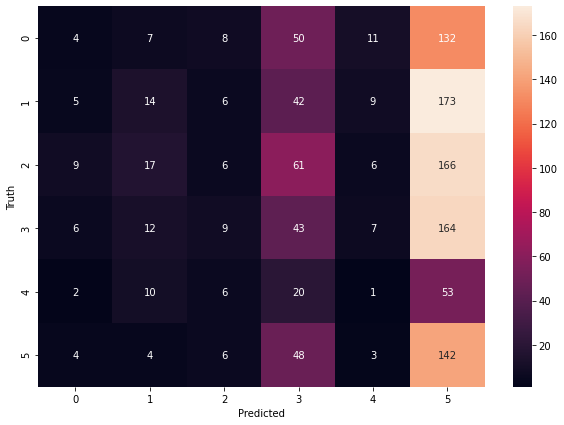

In [30]:
import seaborn as sn
import matplotlib.pyplot as plt
plt.figure(figsize = (10,7))
sn.heatmap(matrix, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [31]:
#labels = ['halfTrue', 'false', 'mostlyTrue', 'barelyTrue', 'true', 'pantsFire']
                0         1          2             3           4        5